# Import Libraries

In [1]:
# For CPU Operations
import time
import logging
import subprocess
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

# For GPU array computation
import cupy as cp

# For GPU dataframe operation
import cudf

# Default DASK Libraries and set use GPU's
import dask
import dask_cudf
import dask.dataframe as dd
dask.config.set({"dataframe.backend": "cudf"})

# Set for Multi GPU use
from dask_cuda        import LocalCUDACluster
from dask.distributed import Client, wait, progress

# Dask Machine Learning Libraries
import dask_ml
from dask_ml.metrics         import mean_squared_error 
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers        import ParallelPostFit

# Import cuml RandomForest
from cuml.ensemble import RandomForestClassifier as RF

# For Visualization
import matplotlib
import matplotlib.pyplot as plt
import graphviz


# Set Multi-GPU Client

In [2]:
cmd = "hostname --all-ip-addresses"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
IPADDR = str(output.decode()).split()[0]

cluster = LocalCUDACluster(ip=IPADDR, silence_logs=logging.ERROR)
client = Client(cluster)

# Check Client

In [3]:
client

<Client: 'tcp://192.168.0.69:41359' processes=2 threads=2, memory=31.27 GiB>

# Load and Preprocessing Bank Account Fraud Dataset

In [4]:
usecols = ["fraud_bool",'income', 'name_email_similarity', 'current_address_months_count',
           "bank_months_count", "prev_address_months_count", "velocity_4w",
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'employment_status', 'credit_risk_score', 'email_is_free',
       'housing_status', 'phone_home_valid', 'phone_mobile_valid',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month']
dask_df = dd.read_csv("../data/bank/Variant*.csv", na_values= ['-1'], usecols=usecols)
dask_df = dask_df.persist()

In [5]:
!ls -lh ../data/bank/

합계 1.3G
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023  Base.csv
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023 'Variant I.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023 'Variant II.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 241M 11월 29  2023 'Variant III.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 204M 11월 29  2023 'Variant IV.csv'
-rw-rw-r-- 1 cvmi_jeyoung cvmi_jeyoung 241M 11월 29  2023 'Variant V.csv'


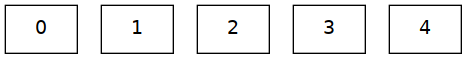

In [6]:
dask_df.visualize()

In [7]:
dask_df.describe()

<dask_cudf.DataFrame | 478 tasks | 1 npartitions>

In [8]:
def LabelEncoder(dd:dask.dataframe)->dask.dataframe:
    columns = dd.columns
    for c in columns:
        categories = dd[c].compute().unique()
        cat_dict   = {c : i for i, c in enumerate(categories.values_host)}
        dd[c] = dd[c].map(cat_dict)
    return dd

def standard_scaler(ddf:dd.DataFrame) -> dd.DataFrame:
    columns = ddf.columns
    for c in columns:
        mean = ddf[c].mean()
        std  = ddf[c].std()
        ddf[c]   = (ddf[c] - mean) / std
    return ddf

In [9]:
label_col = list(dask_df.select_dtypes(include=["object", "category"]).columns)
scale_col = list(dask_df.select_dtypes(include=["number"]).columns[1:])
dask_df[label_col] = LabelEncoder(dask_df[label_col])
dask_df[scale_col] = standard_scaler(dask_df[scale_col])
dask_df = dask_df.drop(["bank_months_count", "prev_address_months_count", "velocity_4w"], axis=1)
dask_df = dask_df.dropna()

train, test = dask_df.random_split([0.8, 0.2])
# train = train.compute().dropna()
# test  = test.compute().dropna()
X_train, y_train = train.drop(["fraud_bool"], axis=1), train[["fraud_bool"]]
X_test,  y_test  = test.drop(["fraud_bool"], axis=1), test[["fraud_bool"]]

# Set RandomForest

In [10]:
%%time
model = ParallelPostFit(estimator=RF(n_estimators=100, max_depth=8))
model.fit(X_train, y_train.compute().to_cupy().flatten())

CPU times: user 15.1 s, sys: 15.4 s, total: 30.6 s
Wall time: 33.2 s


ParallelPostFit(estimator=RandomForestClassifier())

# Test Random Forest

In [11]:
pred = model.predict(X_test)

In [12]:
pred = cp.asnumpy(pred.compute().to_cupy())
gt   = cp.asnumpy(y_test.compute().to_cupy().flatten())
accuracy = np.where(pred==gt, 1, 0).sum() / len(gt)
print(f"Accuracy : {accuracy:.2f}%")

Accuracy : 0.99%
